In [1]:
# CELL 1: Imports, device, seed, small helpers
import os
import random
from pathlib import Path
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms.functional as TF
import torchvision.models as models

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

# small utility functions
def safe_mkdir(path):
    os.makedirs(path, exist_ok=True)

Device: cuda


In [2]:
# ============================================================================
# ALBUMENTATIONS 2.0.8 — STRICT SAFE VERSION (NO INVALID ARGS)
# ============================================================================

import albumentations as A
from albumentations.pytorch import ToTensorV2

IMAGE_SIZE = (256, 256)

train_transform = A.Compose([
    # ---------------------------------------------------
    # Geometric
    # ---------------------------------------------------
    A.RandomResizedCrop(
        size=IMAGE_SIZE,    # ✔ only valid way
        scale=(0.85, 1.0),
        ratio=(0.9, 1.1),
        p=1.0
    ),

    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),

    A.Affine(
        scale=(0.95, 1.05),
        translate_percent=(0.02, 0.04),
        rotate=(-12, 12),
        shear=(-5, 5),
        p=0.4
    ),

    # ---------------------------------------------------
    # Mild color transforms
    # ---------------------------------------------------
    A.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.05,
        p=0.4
    ),

    # ---------------------------------------------------
    # Noise (no args allowed in your version)
    # ---------------------------------------------------
    A.GaussNoise(p=0.25),

    # ---------------------------------------------------
    # Blur
    # ---------------------------------------------------
    A.GaussianBlur(blur_limit=3, p=0.25),

    # ---------------------------------------------------
    # Normalize + tensor
    # ---------------------------------------------------
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
    ToTensorV2()
])


val_transform = A.Compose([
    A.Resize(
        height=IMAGE_SIZE[0],
        width=IMAGE_SIZE[1]
    ),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])

print("✅ Albumentations transforms loaded successfully (2.0.8 safe mode)")

✅ Albumentations transforms loaded successfully (2.0.8 safe mode)


In [3]:

import cv2
import numpy as np
from pathlib import Path

class LeafMaskGenerator:
    """
    Generates leaf masks for PlantDoc dataset using multiple strategies
    """
    
    def __init__(self, strategy='combined'):
        self.strategy = strategy
    
    def generate_leaf_mask_green(self, img):
        """Strategy 1: LAB color space green channel thresholding"""
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        
        # Green is low 'a' channel value
        green_mask = (a < 120).astype(np.uint8)
        bright_mask = (l > 30).astype(np.uint8)
        mask = green_mask & bright_mask
        
        # Morphological cleanup
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
        
        return mask
    
    def generate_leaf_mask_hsv(self, img):
        """Strategy 2: HSV-based vegetation segmentation"""
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)
        
        hue_mask = ((h >= 25) & (h <= 95)).astype(np.uint8)
        sat_mask = (s > 20).astype(np.uint8)
        val_mask = (v > 30).astype(np.uint8)
        
        mask = hue_mask & sat_mask & val_mask
        
        # Morphological cleanup
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
        
        return mask
    
    def generate_leaf_mask_combined(self, img, disease_mask=None):
        """Strategy 5: Combine multiple methods (RECOMMENDED)"""
        h, w = img.shape[:2]
        
        # LAB green channel
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        mask_green = ((a < 120) & (l > 30)).astype(np.uint8)
        
        # HSV vegetation
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h_chan, s, v = cv2.split(hsv)
        mask_hsv = ((h_chan >= 25) & (h_chan <= 95) & 
                    (s > 20) & (v > 30)).astype(np.uint8)
        
        # Union of both
        mask_combined = ((mask_green + mask_hsv) > 0).astype(np.uint8)
        
        # If disease mask exists, ensure it's included
        if disease_mask is not None and disease_mask.sum() > 0:
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
            disease_expanded = cv2.dilate(disease_mask, kernel, iterations=2)
            mask_combined = ((mask_combined + disease_expanded) > 0).astype(np.uint8)
        
        # Final cleanup
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, 
                                        kernel, iterations=2)
        
        # Remove small noise
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
            mask_combined, connectivity=8)
        if num_labels > 1:
            min_area = (img.shape[0] * img.shape[1]) * 0.01
            for i in range(1, num_labels):
                if stats[i, cv2.CC_STAT_AREA] < min_area:
                    mask_combined[labels == i] = 0
        
        return mask_combined
    
    def generate(self, img, disease_mask=None):
        """Main generation method"""
        if self.strategy == 'green':
            return self.generate_leaf_mask_green(img)
        elif self.strategy == 'hsv':
            return self.generate_leaf_mask_hsv(img)
        elif self.strategy == 'combined':
            return self.generate_leaf_mask_combined(img, disease_mask)
        else:
            return self.generate_leaf_mask_combined(img, disease_mask)

print("✅ LeafMaskGenerator class loaded")

✅ LeafMaskGenerator class loaded


In [4]:
# ============================================================================
# CELL 3 — FIXED DATASET CLASSES (ALL BUGS CORRECTED)
# ============================================================================

import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
from pathlib import Path
import torchvision.transforms.functional as TF


# -------------------------------------------
# CVPPP DATASET
# -------------------------------------------
class CVPPPDataset(Dataset):
    def __init__(self, root_dir, split='train', image_size=(256,256), transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_size = image_size

        self.image_files = sorted([p for p in self.root_dir.glob("**/*_rgb.png") if not p.name.startswith("._")])
        split_idx = int(len(self.image_files) * 0.8)

        if split == 'train':
            self.image_files = self.image_files[:split_idx]
        else:
            self.image_files = self.image_files[split_idx:]

        print(f"✅ CVPPP {split}: {len(self.image_files)} images")

    def __len__(self):
        return len(self.image_files)

    def _load_image(self, p):
        img = cv2.imread(str(p))
        if img is None:
            img = np.zeros((*self.image_size, 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.image_size)
        return img

    def _load_instances(self, img_path):
        base = img_path.stem.replace("_rgb", "")
        label_files = sorted(img_path.parent.glob(f"{base}_label*.png"))

        if not label_files:
            label_files = sorted(img_path.parent.glob(f"{base}_fg*.png"))

        masks = []
        for lf in label_files:
            m = cv2.imread(str(lf), cv2.IMREAD_GRAYSCALE)
            if m is not None:
                m = cv2.resize(m, self.image_size, interpolation=cv2.INTER_NEAREST)
                masks.append((m > 0).astype(np.uint8))

        if len(masks) == 0:
            masks = np.zeros((1, *self.image_size), dtype=np.uint8)
        else:
            masks = np.stack(masks, axis=0)

        return masks

    def __getitem__(self, idx):
        p = self.image_files[idx]
        img = self._load_image(p)
        leaf_instances = self._load_instances(p)

        if self.transform:
            aug = self.transform(image=img, masks=list(leaf_instances))
            img = aug["image"]
            masks_aug = np.stack(aug["masks"], axis=0).astype(np.float32)
            return img, {
                "dataset": "cvppp",
                "leaf_instances": torch.from_numpy(masks_aug)
            }

        return TF.to_tensor(img).float(), {
            "dataset": "cvppp",
            "leaf_instances": torch.from_numpy(leaf_instances.astype(np.float32))
        }


# -------------------------------------------
# PLANTDOC DATASET - FIXED VERSION
# -------------------------------------------

class PlantDocDiseaseDataset(Dataset):
    """
    PlantDoc dataset with automatic leaf mask generation
    """
    
    def __init__(self, root_dir, split='train', image_size=(256, 256), 
                 transform=None, leaf_strategy='combined'):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_size = image_size
        self.leaf_strategy = leaf_strategy
        
        # Detect paths
        self.image_dir, self.mask_dir = self._detect_paths()
        
        # Load file list
        files = sorted(list(self.image_dir.glob("*.jpg")) + 
                      list(self.image_dir.glob("*.png")))
        
        if len(files) == 0:
            raise ValueError(f"❌ No images found in {self.image_dir}")
        
        # Train/val split
        idx = int(len(files) * 0.8)
        if split == 'train':
            self.image_files = files[:idx]
        else:
            self.image_files = files[idx:]
        
        # Initialize leaf mask generator
        self.leaf_generator = LeafMaskGenerator(strategy=leaf_strategy)
        
        print(f"✅ PlantDoc {split}: {len(self.image_files)} images "
              f"(leaf_strategy={leaf_strategy})")
    
    def _detect_paths(self):
        """Detect image and mask directories"""
        possible_images = [
            self.root_dir / "aug_data" / "aug_data" / "images",
            self.root_dir / "aug_data" / "images",
            self.root_dir / "images",
            self.root_dir / "train" / "images",
        ]
        possible_masks = [
            self.root_dir / "aug_data" / "aug_data" / "masks",
            self.root_dir / "aug_data" / "masks",
            self.root_dir / "masks",
            self.root_dir / "train" / "masks",
        ]
        
        image_dir = next((p for p in possible_images if p.exists()), None)
        mask_dir = next((p for p in possible_masks if p.exists()), None)
        
        if image_dir is None or mask_dir is None:
            raise ValueError(
                f"❌ PlantDoc images/masks not found in {self.root_dir}\n"
                f"   Image dir: {image_dir}\n"
                f"   Mask dir: {mask_dir}"
            )
        
        return image_dir, mask_dir
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        p = self.image_files[idx]
        
        # Load image
        img = cv2.imread(str(p))
        if img is None:
            dummy = torch.zeros(3, *self.image_size)
            mask = torch.zeros(1, *self.image_size)
            return dummy, {
                "dataset": "plantdoc",
                "leaf_instances": mask,
                "leaf_mask": mask.squeeze(0),
                "disease_spots": mask.squeeze(0)
            }
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.image_size)
        
        # Load disease mask
        mask_path = self.mask_dir / f"{p.stem}.png"
        if not mask_path.exists():
            mask_path = self.mask_dir / f"{p.stem}.jpg"
        
        disease_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if disease_mask is None:
            disease_mask = np.zeros(self.image_size, dtype=np.uint8)
        else:
            disease_mask = cv2.resize(disease_mask, self.image_size, 
                                     interpolation=cv2.INTER_NEAREST)
        
        disease_mask = (disease_mask > 0).astype(np.uint8)
        
        # ✅ GENERATE LEAF MASK (NEW!)
        leaf_mask = self.leaf_generator.generate(img, disease_mask)
        
        # Apply augmentation
        if self.transform:
            aug = self.transform(image=img, masks=[leaf_mask, disease_mask])
            img_t = aug["image"]
            masks_aug = aug["masks"]
            
            # Handle mask conversion
            if len(masks_aug) >= 2:
                leaf_mask_aug = masks_aug[0]
                disease_mask_aug = masks_aug[1]
            else:
                leaf_mask_aug = leaf_mask
                disease_mask_aug = disease_mask
            
            # Convert to tensors
            leaf_mask_t = self._to_tensor(leaf_mask_aug)
            disease_mask_t = self._to_tensor(disease_mask_aug)
        else:
            img_t = TF.to_tensor(img).float()
            leaf_mask_t = torch.from_numpy(leaf_mask.astype(np.float32))
            disease_mask_t = torch.from_numpy(disease_mask.astype(np.float32))
        
        # Ensure 2D shape [H, W]
        if leaf_mask_t.ndim == 3:
            leaf_mask_t = leaf_mask_t.squeeze(0)
        if disease_mask_t.ndim == 3:
            disease_mask_t = disease_mask_t.squeeze(0)
        
        # Create leaf_instances [1, H, W]
        leaf_instances_t = leaf_mask_t.unsqueeze(0)
        
        return img_t, {
            "dataset": "plantdoc",
            "leaf_instances": leaf_instances_t,  # [1, 256, 256]
            "leaf_mask": leaf_mask_t,            # [256, 256]
            "disease_spots": disease_mask_t      # [256, 256]
        }
    
    @staticmethod
    def _to_tensor(mask):
        """Convert mask to tensor"""
        if isinstance(mask, np.ndarray):
            return torch.from_numpy(mask).float()
        elif isinstance(mask, torch.Tensor):
            return mask.float()
        else:
            return torch.from_numpy(np.asarray(mask)).float()

print("✅ PlantDocDiseaseDataset class updated with leaf mask generation")


# -------------------------------------------
# MULTI-DATASET LOADER
# -------------------------------------------
class MultiDatasetHierarchicalLoader(Dataset):
    def __init__(self, cvppp_dir=None, plantdoc_dir=None, split='train', transform=None):
        self.transform = transform
        self.samples = []

        if cvppp_dir:
            self.cvppp = CVPPPDataset(cvppp_dir, split=split, transform=transform)
            self.samples += [("cvppp", i) for i in range(len(self.cvppp))]
        else:
            self.cvppp = None

        if plantdoc_dir:
            self.plantdoc = PlantDocDiseaseDataset(plantdoc_dir, split=split, transform=transform)
            self.samples += [("plantdoc", i) for i in range(len(self.plantdoc))]
        else:
            self.plantdoc = None

        print(f"\n✅ Combined dataset: total {len(self.samples)} samples (cvppp={len(self.cvppp or [])}, plantdoc={len(self.plantdoc or [])})")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        src, i = self.samples[idx]
        return (self.cvppp[i] if src == "cvppp" else self.plantdoc[i])

# -------------------------------------------
# COLLATE FN
# -------------------------------------------
def hierarchical_collate_fn(batch):
    images = torch.stack([b[0] for b in batch], dim=0)
    targets_list = [b[1] for b in batch]

    datasets = []
    leaf_instances_list = []
    leaf_mask_list = []
    disease_mask_list = []

    for t in targets_list:
        datasets.append(t["dataset"])

        # -------------------------------
        # 1. leaf instances (keep full)
        # -------------------------------
        inst = t.get("leaf_instances", None)
        if inst is None:
            inst = torch.zeros((1, 256, 256))
        # ensure shape [N,256,256]
        if inst.ndim == 4:
            inst = inst.squeeze(1)
        leaf_instances_list.append(inst)

        # -------------------------------
        # 2. leaf_mask (always union mask)
        # -------------------------------
        if inst is not None:
            lm = (inst.max(dim=0)[0] > 0).float()   # union of instances
        else:
            lm = t.get("leaf_mask", torch.zeros((256,256))).float()

        # ensure [256,256]
        if lm.ndim == 3:
            lm = lm.squeeze(0)
        leaf_mask_list.append(lm)

        # -------------------------------
        # 3. disease_spots
        # -------------------------------
        dm = t.get("disease_spots", torch.zeros((256,256))).float()
        if dm.ndim == 3:
            dm = dm.squeeze(0)
        disease_mask_list.append(dm)

    # Pad leaf instances to same N across batch
    max_inst = max(inst.shape[0] for inst in leaf_instances_list)
    padded_instances = []
    for inst in leaf_instances_list:
        if inst.shape[0] < max_inst:
            pad = torch.zeros(
                (max_inst - inst.shape[0], 256, 256),
                dtype=inst.dtype
            )
            inst = torch.cat([inst, pad], dim=0)
        padded_instances.append(inst)

    return (
        images,
        {
            "dataset": datasets,
            "leaf_instances": torch.stack(padded_instances),  # [B, N,256,256]
            "leaf_mask": torch.stack(leaf_mask_list),         # [B,256,256]
            "disease_spots": torch.stack(disease_mask_list)   # [B,256,256]
        }
    )

✅ PlantDocDiseaseDataset class updated with leaf mask generation


In [5]:


# ============================================================================
# CELL 3C: OPTIONAL - VISUALIZATION FUNCTION
# Add this to verify leaf masks are working correctly
# ============================================================================

def visualize_sample_with_leaf_masks(dataset, idx=0, save_path='sample_with_leafmask.png'):
    """Visualize a sample to verify leaf masks"""
    img_t, targets = dataset[idx]
    
    # Convert tensor back to numpy for visualization
    img = img_t.permute(1, 2, 0).cpu().numpy()
    
    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    leaf_mask = targets['leaf_mask'].cpu().numpy()
    disease_mask = targets['disease_spots'].cpu().numpy()
    
    # Calculate metrics
    leaf_pixels = leaf_mask.sum()
    disease_pixels = disease_mask.sum()
    inside = (leaf_mask * disease_mask).sum()
    hierarchy_score = inside / (disease_pixels + 1e-6)
    
    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(img)
    axes[1].imshow(leaf_mask, alpha=0.5, cmap='Greens')
    axes[1].set_title(f'Leaf Mask\n({leaf_pixels:.0f} pixels)')
    axes[1].axis('off')
    
    axes[2].imshow(img)
    axes[2].imshow(disease_mask, alpha=0.5, cmap='Reds')
    axes[2].set_title(f'Disease Mask\n({disease_pixels:.0f} pixels)')
    axes[2].axis('off')
    
    axes[3].imshow(img)
    axes[3].imshow(leaf_mask, alpha=0.3, cmap='Greens')
    axes[3].imshow(disease_mask, alpha=0.5, cmap='Reds')
    axes[3].set_title(f'Overlay\nHierarchy: {hierarchy_score:.2%}')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Sample Statistics:")
    print(f"  Leaf pixels: {leaf_pixels:.0f}")
    print(f"  Disease pixels: {disease_pixels:.0f}")
    print(f"  Disease inside leaf: {inside:.0f} ({100*inside/(disease_pixels+1e-6):.1f}%)")
    print(f"  Hierarchy score: {hierarchy_score:.4f}")

print("✅ Visualization function loaded")

✅ Visualization function loaded


In [6]:

print("🔄 Creating datasets with automatic leaf mask generation...\n")

# Paths
CVPPP_TRAINING_DIR = "/kaggle/input/cvppp-2017-dataset"
PLANTDOC_DISEASE_DIR = "/kaggle/input/leaf-disease-segmentation-dataset"

BATCH_SIZE = 4
NUM_EPOCHS = 20

# Create datasets
train_dataset = MultiDatasetHierarchicalLoader(
    cvppp_dir=CVPPP_TRAINING_DIR, 
    plantdoc_dir=PLANTDOC_DISEASE_DIR, 
    split='train', 
    transform=train_transform
)

val_dataset = MultiDatasetHierarchicalLoader(
    cvppp_dir=CVPPP_TRAINING_DIR, 
    plantdoc_dir=PLANTDOC_DISEASE_DIR, 
    split='val', 
    transform=val_transform
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2, 
    collate_fn=hierarchical_collate_fn, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2, 
    collate_fn=hierarchical_collate_fn, 
    pin_memory=True
)

print("\n✅ Datasets and dataloaders created!")
print(f"   Train samples: {len(train_dataset)}")
print(f"   Val samples: {len(val_dataset)}")

🔄 Creating datasets with automatic leaf mask generation...

✅ CVPPP train: 648 images
✅ PlantDoc train: 2352 images (leaf_strategy=combined)

✅ Combined dataset: total 3000 samples (cvppp=648, plantdoc=2352)
✅ CVPPP val: 162 images
✅ PlantDoc val: 588 images (leaf_strategy=combined)

✅ Combined dataset: total 750 samples (cvppp=162, plantdoc=588)

✅ Datasets and dataloaders created!
   Train samples: 3000
   Val samples: 750


In [7]:
missing = []
for i in range(len(train_dataset)):
    _, t = train_dataset[i]
    if 'leaf_mask' not in t:
        missing.append(i)

print("Missing leaf_mask at indices:", missing[:50])
print("Total missing:", len(missing))

Missing leaf_mask at indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Total missing: 648


In [8]:
def visualize_sample_with_leaf_masks(src, idx=0, save_path=None):
    """
    Visualize a sample either from the dataset (dataset[idx])
    or a batch (images, targets).
    """

    # -------------------------------------------------
    # 1) Retrieve (image, targets) depending on input type
    # -------------------------------------------------
    if isinstance(src, tuple):
        # batch from DataLoader
        images, targets = src
        img = images[idx].permute(1, 2, 0).cpu().numpy()
        t = {k: v[idx] for k, v in targets.items()}
    else:
        # raw dataset
        img, t = src[idx]
        img = img.permute(1, 2, 0).cpu().numpy()

    img = np.clip(img, 0, 1)

    print(f"\n[DEBUG] Visualizing sample {idx}")
    print("Target keys:", t.keys())

    # -------------------------------------------------
    # 2) Retrieve leaf mask (with fallback)
    # -------------------------------------------------
    if 'leaf_mask' in t:
        leaf_mask = t['leaf_mask']
    elif 'leaf_instances' in t:
        print(f"[WARN] 'leaf_mask' missing → generating from 'leaf_instances'")
        leaf_mask = (t['leaf_instances'] > 0).float()
    else:
        raise KeyError(f"Sample {idx} has no leaf_mask or leaf_instances")

    leaf_mask = leaf_mask.squeeze().cpu().numpy()

    # -------------------------------------------------
    # 3) Retrieve disease mask (fallback to zeros)
    # -------------------------------------------------
    if 'disease_spots' in t:
        disease_mask = t['disease_spots'].squeeze().cpu().numpy()
    else:
        print(f"[WARN] 'disease_spots' missing → creating blank mask")
        disease_mask = np.zeros_like(leaf_mask)

    # -------------------------------------------------
    # 4) Plot
    # -------------------------------------------------
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))

    axes[0].imshow(img)
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(leaf_mask, cmap='Greens')
    axes[1].set_title("Leaf Mask")
    axes[1].axis("off")

    axes[2].imshow(disease_mask, cmap='Reds')
    axes[2].set_title("Disease Spots")
    axes[2].axis("off")

    overlay = img.copy()
    overlay_red = overlay.copy()
    overlay_red[..., 0] = np.maximum(overlay_red[..., 0], disease_mask)
    overlay_green = overlay_red.copy()
    overlay_green[..., 1] = np.maximum(overlay_green[..., 1], leaf_mask)

    axes[3].imshow(overlay_green)
    axes[3].set_title("Overlay")
    axes[3].axis("off")

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization → {save_path}")

    plt.show()

In [9]:
# ============================================================
# CELL 4 — ConvNeXt-Tiny backbone + two-head segmentation model
# ✓ Same API as your previous ResNet model
# ✓ Same output dict structure
# ✓ Fully compatible with your loss + training loop
# ============================================================
""""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights


class ConvNeXtTinyHierarchical(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        # --------------------------------------------------------
        # Load ConvNeXt-Tiny backbone (features only)
        # --------------------------------------------------------
        weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = convnext_tiny(weights=weights)

        # ConvNeXt outputs a feature map of size: B x 768 x H/32 x W/32
        self.encoder = backbone.features
        enc_ch = 768  # ConvNeXt-Tiny final channels

        # --------------------------------------------------------
        # Shared decoder (simple but strong)
        # --------------------------------------------------------
        self.decoder = nn.Sequential(
            nn.Conv2d(enc_ch, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.GELU(),

            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
        )

        # --------------------------------------------------------
        # Leaf head  (segmentation of leaf areas)
        # --------------------------------------------------------
        self.leaf_head = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 1, 1)
        )

        # --------------------------------------------------------
        # Disease head  (small lesion detection)
        # --------------------------------------------------------
        self.disease_head = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 1, 1)
        )

    def forward(self, x):
        # encoder
        feats = self.encoder(x)     # B x 768 x 8x8  (for 256x256 input)

        # shared decoder
        dec = self.decoder(feats)   # B x 256 x 8x8

        # raw (low-res) logits — loss will upsample them to 256×256
        leaf_logits = self.leaf_head(dec).squeeze(1)      # B x 8 x 8
        disease_logits = self.disease_head(dec).squeeze(1)

        return {
            "instance": {"leaf_masks": leaf_logits},   # same structure as before
            "disease": disease_logits
        }


# --------------------------------------------------------
# Builder function (keeps SAME NAME as before!)
# --------------------------------------------------------
def build_model(pretrained=True):
    model = ConvNeXtTinyHierarchical(pretrained=pretrained)
    return model.to(device)
 """"

SyntaxError: incomplete input (37984704.py, line 7)

In [25]:
# ============================================================================
# CELL 4 — ConvNeXt-Base backbone + two-head hierarchical segmentation model
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import convnext_base, ConvNeXt_Base_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ConvNeXtBaseHierarchical(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        # ------------------------------------------------------------
        # Load ConvNeXt-Base backbone
        # ------------------------------------------------------------
        if pretrained:
            weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
        else:
            weights = None

        backbone = convnext_base(weights=weights)

        # ConvNeXt-Base final feature dim: 1024
        self.encoder = backbone.features      # output: (B, 1024, 8, 8)
        enc_ch = 1024

        # ------------------------------------------------------------
        # Shared decoder
        # ------------------------------------------------------------
        self.decoder = nn.Sequential(
            nn.Conv2d(enc_ch, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.GELU(),

            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
        )

        # ------------------------------------------------------------
        # Leaf head  (leaf segmentation)
        # ------------------------------------------------------------
        self.leaf_head = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 1, 1)       # output low-res logits
        )

        # ------------------------------------------------------------
        # Disease head (lesion segmentation)
        # ------------------------------------------------------------
        self.disease_head = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 1, 1)       # output low-res logits
        )

        # ============================================================
        # FIX: ensure ALL parameters go to GPU inside __init__
        # ============================================================
        self.to(device)


    def forward(self, x):

        # Encoder
        feats = self.encoder(x)       # B × 1024 × 8 × 8

        # Decoder shared
        dec = self.decoder(feats)     # B × 256 × 8 × 8

        # Low-res heads (upsampled later in the loss)
        leaf_logits = self.leaf_head(dec).squeeze(1)       # B × 8 × 8
        disease_logits = self.disease_head(dec).squeeze(1)

        # Keep SAME output structure your loss expects
        return {
            "instance": {"leaf_masks": leaf_logits},
            "disease": disease_logits
        }


# ============================================================
# Builder function (same name as before)
# ============================================================
def build_convnext_tiny(pretrained=True):
    """
    NOTE: Name kept the same so rest of your code does NOT break.
    It now returns ConvNeXt-Base instead of Tiny.
    """
    model = ConvNeXtBaseHierarchical(pretrained=pretrained)
    return model


In [26]:
# ======================================================
# FIXED COMBINED LOSS - COMPLETE VERSION
# ======================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------
# Dice Loss for segmentation
# ----------------------------
def dice_loss_logits(pred_logits, target, eps=1e-6):
    pred = torch.sigmoid(pred_logits)
    intersection = (pred * target).sum(dim=(-2,-1))
    union = pred.sum(dim=(-2,-1)) + target.sum(dim=(-2,-1))
    loss = 1 - (2*intersection + eps) / (union + eps)
    return loss.mean()


# ----------------------------
# IoU from logits
# ----------------------------
def iou_from_logits(pred_logits, target, threshold=0.5, eps=1e-6):
    pred = (torch.sigmoid(pred_logits) > threshold).float()
    inter = (pred * target).sum()
    union = ((pred + target) > 0).float().sum()
    return (inter + eps) / (union + eps)


# ======================================================
# COMPLETE COMBINED LOSS WITH ALL FIXES
# ======================================================
class CombinedLoss(nn.Module):
    def __init__(
        self,
        device='cuda',
        disease_pos_weight=30.0,
        disease_weight=12.0,
        leaf_weight=1.0,
        hierarchy_weight=5.0,   # stronger hierarchy
        spatial_mask_weight=3.0 # spatial enforcement
    ):
        super().__init__()
        self.device = device
        self.disease_pos_weight = disease_pos_weight
        self.disease_weight = disease_weight
        self.leaf_weight = leaf_weight
        self.hierarchy_weight = hierarchy_weight
        self.spatial_mask_weight = spatial_mask_weight

        # BCE with class weighting for disease sparsity
        self.bce_logits = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor([disease_pos_weight], device=device)
        )
    
    def _extract_tensor_recursive(self, obj):
        """Recursively return the first torch.Tensor found in obj (or None)."""
        if torch.is_tensor(obj):
            return obj
        if isinstance(obj, dict):
            # prefer commonly used keys first
            for key in ("leaf_masks", "logits", "mask", "pred", "out"):
                if key in obj and torch.is_tensor(obj[key]):
                    return obj[key]
            for v in obj.values():
                t = self._extract_tensor_recursive(v)
                if t is not None:
                    return t
        if isinstance(obj, (list, tuple)):
            for v in obj:
                t = self._extract_tensor_recursive(v)
                if t is not None:
                    return t
        return None
    
    
    def forward(self, outputs, targets):
        """
        Robust forward that accepts:
          - outputs being dict-like (possibly nested)
          - or a raw tensor [B,2,H,W]
        and extracts:
          pred_leaf -> [B,1,H1,W1] tensor (logits)
          pred_disease -> [B,1,H1,W1] tensor (logits)
        """
        # -------------------------
        # Extract leaf logits
        # -------------------------
        pred_leaf = None
        pred_disease = None
    
        # If dict-like (including autocast wrappers that implement .keys)
        if isinstance(outputs, dict) or hasattr(outputs, "keys"):
            # instance head may be nested dict
            if "instance" in outputs:
                inst = outputs["instance"]
                # try common nested key first
                if isinstance(inst, dict) and "leaf_masks" in inst:
                    pred_leaf = inst["leaf_masks"]
                else:
                    pred_leaf = self._extract_tensor_recursive(inst)
    
            # disease head may be tensor or nested
            if "disease" in outputs:
                disease_obj = outputs["disease"]
                pred_disease = self._extract_tensor_recursive(disease_obj)
    
            # torchvision style "out" may hold logits [B,2,H,W]
            if pred_leaf is None and "out" in outputs:
                logits = outputs["out"]
                if logits.dim() == 4 and logits.shape[1] >= 2:
                    pred_leaf = logits[:, 0:1, :, :]
                    pred_disease = logits[:, 1:2, :, :]
    
        else:
            # assume raw tensor [B,2,H,W]
            if torch.is_tensor(outputs) and outputs.dim() == 4 and outputs.shape[1] >= 2:
                pred_leaf = outputs[:, 0:1, :, :]
                pred_disease = outputs[:, 1:2, :, :]
    
        # final safety checks
        if pred_leaf is None:
            raise RuntimeError(f"Could not extract leaf logits from model outputs: keys={getattr(outputs, 'keys', lambda: None)() if hasattr(outputs, 'keys') else type(outputs)}")
        if pred_disease is None:
            raise RuntimeError(f"Could not extract disease logits from model outputs: keys={getattr(outputs, 'keys', lambda: None)() if hasattr(outputs, 'keys') else type(outputs)}")
    
        # ensure tensors (they may be numpy etc.)
        if not torch.is_tensor(pred_leaf):
            pred_leaf = torch.as_tensor(pred_leaf)
        if not torch.is_tensor(pred_disease):
            pred_disease = torch.as_tensor(pred_disease)
    
        device = pred_leaf.device
    
        # ensure shape [B,1,H,W]
        if pred_leaf.dim() == 3:
            pred_leaf = pred_leaf.unsqueeze(1)
        if pred_disease.dim() == 3:
            pred_disease = pred_disease.unsqueeze(1)
    
        # Upsample logits to training GT size (256x256) if necessary
        if pred_leaf.shape[-2:] != (256, 256):
            pred_leaf = F.interpolate(pred_leaf, size=(256, 256), mode='bilinear', align_corners=False)
        if pred_disease.shape[-2:] != (256, 256):
            pred_disease = F.interpolate(pred_disease, size=(256, 256), mode='bilinear', align_corners=False)
    
        # --- Get GT, move to device ---
        leaf_mask = targets["leaf_mask"].float().to(device)
        disease_mask = targets["disease_spots"].float().to(device)
        # ensure [B,1,H,W]
        if leaf_mask.dim() == 3:
            leaf_mask = leaf_mask.unsqueeze(1)
        if disease_mask.dim() == 3:
            disease_mask = disease_mask.unsqueeze(1)
    
        # ============================
        # Loss components (same as before)
        # ============================
        leaf_loss = F.binary_cross_entropy_with_logits(pred_leaf, leaf_mask)
        disease_loss = self.bce_logits(pred_disease, disease_mask)
    
        pred_disease_prob = torch.sigmoid(pred_disease)
        pred_leaf_prob = torch.sigmoid(pred_leaf)
        outside_leaf = pred_disease_prob * (1 - pred_leaf_prob)
        hierarchy_loss = outside_leaf.mean()
    
        dy = torch.abs(pred_leaf[:, :, 1:, :] - pred_leaf[:, :, :-1, :]).mean()
        dx = torch.abs(pred_leaf[:, :, :, 1:] - pred_leaf[:, :, :, :-1]).mean()
        spatial_loss = dx + dy
    
        total_loss = (
            self.leaf_weight * leaf_loss +
            self.disease_weight * disease_loss +
            self.hierarchy_weight * hierarchy_loss +
            self.spatial_mask_weight * spatial_loss
        )
    
        return total_loss, {
            "leaf_loss": leaf_loss.item(),
            "disease_loss": disease_loss.item(),
            "hierarchy_loss": hierarchy_loss.item(),
            "spatial_loss": spatial_loss.item(),
            "total_loss": float(total_loss.detach().cpu())
        }

# ----------------------------
# IoU helper for validation
# ----------------------------
def calculate_iou_logits(logits, target, threshold=0.5):
    logits = logits.detach()
    pred = (torch.sigmoid(logits) > threshold).float()
    inter = (pred * target).sum()
    union = ((pred + target) > 0).float().sum()
    return float((inter + 1e-6) / (union + 1e-6))

In [27]:
# ============================================================================
# CELL 6: Build model, compute boosted pos_weight, and optimizer grouping
# ============================================================================

import torch
import torch.optim as optim
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------- Settings ----------------
NUM_EPOCHS = 20
BATCH_SIZE = 4
BASE_LR = 1e-4
DISEASE_LR = 5e-4
WEIGHT_DECAY = 1e-4

RECOMMENDED = {
    "disease_weight": 12.0,
    "leaf_weight": 1.0,
    "hierarchy_weight": 5.0,
    "pos_weight_min": 15.0,
    "pos_weight_max": 60.0,
    "disease_threshold": 0.2
}

# ===================================================================================
# POS WEIGHT COMPUTATION (FIXED SYNTAX)
# ===================================================================================
def compute_disease_pos_weight(dataset, sample_count=None):
    import numpy as np, random, torch

    n_total = len(dataset)
    if n_total == 0:
        return 1.0

    if sample_count is None or sample_count >= n_total:
        indices = range(n_total)
    else:
        indices = random.sample(range(n_total), min(sample_count, n_total))

    pos = 0
    total = 0

    for i in indices:
        sample = dataset[i]  # (image, targets)
        if sample is None:
            continue

        _, t = sample
        mask = None

        # Priority: disease → leaf → instances
        if "disease_spots" in t:
            mask = t["disease_spots"]
        elif "leaf_mask" in t:
            mask = t["leaf_mask"]
        elif "leaf_instances" in t:
            inst = t["leaf_instances"]
            if isinstance(inst, torch.Tensor):
                mask = (inst.max(dim=0)[0] > 0).float()

        if mask is None:
            continue

        arr = mask.detach().cpu().numpy() if isinstance(mask, torch.Tensor) else np.array(mask)
        if arr.ndim == 3:    # (1,H,W)
            arr = arr[0]

        pos += (arr > 0.5).sum()
        total += arr.size

    if total == 0 or pos == 0:
        return 1.0

    neg = total - pos
    pw = float(neg) / float(pos)

    # clamp into recommended range
    pw = max(RECOMMENDED["pos_weight_min"], min(pw, RECOMMENDED["pos_weight_max"]))
    return float(pw)

# ===================================================================================
# MODEL BUILDER (ConvNeXt-Tiny)
# ===================================================================================
def build_convnext_tiny(pretrained=True):
    model = ConvNeXtBaseHierarchical(pretrained=True).to(device)

    return model.to(device)

# ===================================================================================
# COMPUTE POS WEIGHT
# ===================================================================================
try:
    print("Estimating disease pos_weight (sample=800)...")
    pos_weight_est = compute_disease_pos_weight(train_dataset, sample_count=800)
except Exception as e:
    print("⚠️ Failed to compute pos_weight:", e)
    pos_weight_est = 20.0

pos_weight_final = float(
    max(RECOMMENDED["pos_weight_min"], min(pos_weight_est, RECOMMENDED["pos_weight_max"]))
)

print("Estimated pos_weight (clamped):", pos_weight_final)

# ===================================================================================
# INSTANTIATE MODEL
# ===================================================================================
model = ConvNeXtBaseHierarchical(pretrained=True)
print("Model created:", type(model).__name__)

# ===================================================================================
# PARAMETER GROUPING
# ===================================================================================
disease_params, leaf_params, other_params = [], [], []

for name, p in model.named_parameters():
    ln = name.lower()
    if "disease" in ln:
        disease_params.append(p)
    elif "leaf" in ln or "instance" in ln:
        leaf_params.append(p)
    else:
        other_params.append(p)

if len(leaf_params) == 0:
    leaf_params = other_params
    other_params = []

optimizer = optim.AdamW([
    {"params": other_params, "lr": BASE_LR},
    {"params": leaf_params, "lr": BASE_LR},
    {"params": disease_params, "lr": DISEASE_LR}
], weight_decay=WEIGHT_DECAY)

# ===================================================================================
# SCHEDULER + CRITERION
# ===================================================================================
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=4, verbose=True
)

criterion = CombinedLoss(
    disease_pos_weight=pos_weight_final,
    disease_weight=RECOMMENDED["disease_weight"],
    leaf_weight=RECOMMENDED["leaf_weight"],
    hierarchy_weight=RECOMMENDED["hierarchy_weight"]
)

print("\n=== FINAL TRAINING CONFIG ===")
print("NUM_EPOCHS:", NUM_EPOCHS)
print("BATCH_SIZE:", BATCH_SIZE)
print("BASE_LR:", BASE_LR, "| DISEASE_LR:", DISEASE_LR)
print("pos_weight:", pos_weight_final)
print("optimizer param groups -> disease:", len(disease_params),
      "leaf:", len(leaf_params), "other:", len(other_params))
print("scheduler:", scheduler.__class__.__name__)


Device: cuda
Estimating disease pos_weight (sample=800)...
Estimated pos_weight (clamped): 15.0
Model created: ConvNeXtBaseHierarchical

=== FINAL TRAINING CONFIG ===
NUM_EPOCHS: 20
BATCH_SIZE: 4
BASE_LR: 0.0001 | DISEASE_LR: 0.0005
pos_weight: 15.0
optimizer param groups -> disease: 6 leaf: 6 other: 348
scheduler: ReduceLROnPlateau


In [28]:
# ============================================================================
# RECREATE CRITERION WITH IMPROVED HIERARCHY ENFORCEMENT
# ============================================================================

import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------- Settings --------------
NUM_EPOCHS = 20
BATCH_SIZE = 4
BASE_LR = 1e-4
DISEASE_LR = 5e-4
WEIGHT_DECAY = 1e-4

# IMPROVED LOSS WEIGHTS for better hierarchy
RECOMMENDED = {
    "disease_weight": 12.0,
    "leaf_weight": 1.0,
    "hierarchy_weight": 5.0,      # Increased from 2.0
    "spatial_mask_weight": 3.0,   # NEW
    "pos_weight_min": 15.0,
    "pos_weight_max": 60.0,
    "disease_threshold": 0.15     # Lower threshold for hierarchy check
}

# Use the pos_weight you computed earlier (or use a default)
try:
    pos_weight_final = pos_weight_final  # From previous cell
except:
    pos_weight_final = 15.0  # Fallback

print("Using pos_weight:", pos_weight_final)

# ============================================
# CREATE NEW CRITERION WITH IMPROVED WEIGHTS
# ============================================
criterion = CombinedLoss(
    device='cuda',
    disease_pos_weight=pos_weight_final,
    disease_weight=RECOMMENDED["disease_weight"],
    leaf_weight=RECOMMENDED["leaf_weight"],
    hierarchy_weight=RECOMMENDED["hierarchy_weight"],      # STRONGER
    spatial_mask_weight=RECOMMENDED["spatial_mask_weight"]  # NEW
)

print("\n✅ Criterion recreated with improved hierarchy enforcement:")
print(f"  disease_weight: {RECOMMENDED['disease_weight']}")
print(f"  leaf_weight: {RECOMMENDED['leaf_weight']}")
print(f"  hierarchy_weight: {RECOMMENDED['hierarchy_weight']} (increased from 2.0)")
print(f"  spatial_mask_weight: {RECOMMENDED['spatial_mask_weight']} (NEW)")
print(f"  disease_pos_weight: {pos_weight_final}")

# Optimizer should already be defined, but if not:
try:
    optimizer
    print("\n✅ Optimizer already exists")
except:
    print("\n⚠️ Creating new optimizer...")
    disease_params, leaf_params, other_params = [], [], []
    for name, p in model.named_parameters():
        ln = name.lower()
        if "disease" in ln:
            disease_params.append(p)
        elif "leaf" in ln or "instance" in ln:
            leaf_params.append(p)
        else:
            other_params.append(p)
    
    if len(leaf_params) == 0:
        leaf_params = other_params
        other_params = []
    
    optimizer = optim.AdamW([
        {'params': other_params, 'lr': BASE_LR},
        {'params': leaf_params, 'lr': BASE_LR},
        {'params': disease_params, 'lr': DISEASE_LR}
    ], weight_decay=WEIGHT_DECAY)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=4, verbose=True
    )

print("\n🚀 Ready to train with improved hierarchy enforcement!")

Using pos_weight: 15.0

✅ Criterion recreated with improved hierarchy enforcement:
  disease_weight: 12.0
  leaf_weight: 1.0
  hierarchy_weight: 5.0 (increased from 2.0)
  spatial_mask_weight: 3.0 (NEW)
  disease_pos_weight: 15.0

✅ Optimizer already exists

🚀 Ready to train with improved hierarchy enforcement!


In [29]:
# DEBUG SHAPE CHECK
model.eval()
with torch.no_grad():
    x = torch.randn(1,3,256,256).to(device)
    out = model(x)
    print("Leaf logits:", out['instance']['leaf_masks'].shape)
    print("Disease:", out['disease'].shape)
up_leaf = F.interpolate(out['instance']['leaf_masks'].unsqueeze(1), size=(256, 256))
up_disease = F.interpolate(out['disease'].unsqueeze(1), size=(256, 256))
print("Upsampled leaf:", up_leaf.shape)
print("Upsampled disease:", up_disease.shape)

Leaf logits: torch.Size([1, 8, 8])
Disease: torch.Size([1, 8, 8])
Upsampled leaf: torch.Size([1, 1, 256, 256])
Upsampled disease: torch.Size([1, 1, 256, 256])


In [30]:
# CELL 7: Training loop (FIXED - ALL BUGS REMOVED)
    """
from torch.cuda.amp import autocast, GradScaler
import time
import numpy as np

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None,
                num_epochs=20, accumulation_steps=1, device=device, earlystop_patience=8,
                save_dir="models"):
    safe_mkdir(save_dir)
    scaler = GradScaler()

    history = {
        "train_loss": [], "val_loss": [],
        "leaf_iou": [], "disease_iou": [],
        "hierarchy": [], "lr": []
    }

    best_composite = -1.0
    patience = 0
    
    for epoch in range(num_epochs):
        t0 = time.time()
        model.train()
        running = 0.0
        itern = 0
        optimizer.zero_grad()
        
        # -------------------------
        # TRAINING LOOP
        # -------------------------
        for batch_idx, (images, targets) in enumerate(train_loader):  # BUG FIX 1: Added batch_idx
            images = images.to(device)
          #Unciimnnet for convnext tiny 
          #  with torch.amp.autocast(device_type="cuda"):
          #      outputs = model(images)
          #      loss, _ = criterion(outputs, targets)
          #      loss = loss / accumulation_steps
                
            # AMP OFF FOR MODEL (ConvNeXt fails in fp16)
            with torch.cuda.amp.autocast(enabled=False):
                outputs = model(images.float())   # ensure fp32
            
            # AMP ON FOR LOSS+BACKWARD
            with torch.cuda.amp.autocast(device_type="cuda"):
                loss, _ = criterion(outputs, targets)

            scaler.scale(loss).backward()

            if (itern + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running += float(loss.item()) * accumulation_steps
            itern += 1
            
            # BUG FIX 2: Moved debug code INSIDE the loop where targets exist
            if epoch == 0 and batch_idx == 0:
                leaf_gt = targets['leaf_mask'][0].cpu().numpy()
                disease_gt = targets['disease_spots'][0].cpu().numpy()
                
                print(f"\n[DEBUG GT ALIGNMENT]")
                print(f"Leaf GT pixels: {leaf_gt.sum()}")
                print(f"Disease GT pixels: {disease_gt.sum()}")
                print(f"Disease inside leaf GT: {(disease_gt * leaf_gt).sum()}")
                print(f"Disease coverage of leaf: {100 * (disease_gt * leaf_gt).sum() / (leaf_gt.sum() + 1e-6):.2f}%")
                
                # Visualize
                plt.figure(figsize=(12,4))
                plt.subplot(131); plt.imshow(leaf_gt); plt.title("Leaf GT")
                plt.subplot(132); plt.imshow(disease_gt); plt.title("Disease GT")
                plt.subplot(133); plt.imshow(disease_gt * leaf_gt); plt.title("Disease inside leaf")
                plt.tight_layout()
                plt.savefig("debug_gt_alignment.png", dpi=150)
                plt.close()
                print(f"Saved debug_gt_alignment.png\n")

        avg_train_loss = running / max(1, itern)

        # -------------------------
        # VALIDATION LOOP
        # -------------------------
        model.eval()
        val_running = 0.0
        leaf_ious = []
        disease_ious = []
        hier_scores = []

        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(val_loader):  # BUG FIX 3: Added batch_idx
                images = images.to(device)
                outputs = model(images)

                loss, _ = criterion(outputs, targets)
                val_running += float(loss.item())

                # prepare GT
                leaf_mask = targets['leaf_mask'].to(device)
                disease_target = targets['disease_spots'].to(device)

                B = images.size(0)

                for b in range(B):

                    # ======== UPSAMPLE BOTH HEADS TO 256×256 ========
                    lgt_up = F.interpolate(
                        outputs['instance']['leaf_masks'][b].unsqueeze(0).unsqueeze(0),
                        size=(256, 256), mode='bilinear', align_corners=False
                    ).squeeze(0)

                    dgt_up = F.interpolate(
                        outputs['disease'][b].unsqueeze(0).unsqueeze(0),
                        size=(256, 256), mode='bilinear', align_corners=False
                    ).squeeze(0)

                    # ======== IoU METRICS ========
                    leaf_i = calculate_iou_logits(
                        lgt_up, leaf_mask[b].unsqueeze(0), threshold=0.5
                    )
                    dis_i = calculate_iou_logits(
                        dgt_up, disease_target[b].unsqueeze(0), threshold=0.3
                    )

                    leaf_ious.append(leaf_i)
                    disease_ious.append(dis_i)

                    # ======== HIERARCHY SCORE ========
                    pred_dis  = (torch.sigmoid(dgt_up) > 0.15).float()
                    pred_leaf = (torch.sigmoid(lgt_up) > 0.40).float()

                    if pred_dis.sum() > 0:
                        hsc = float((pred_dis * pred_leaf).sum() / (pred_dis.sum() + 1e-6))
                    else:
                        hsc = 0.0

                    hier_scores.append(hsc)
                    
                    # BUG FIX 4: Moved debug inside the batch loop where pred_dis/pred_leaf exist
                    if epoch == 0 and batch_idx == 0 and b == 0:
                        print("[DEBUG PREDICTIONS]")
                        print(f"  leaf_pixels: {pred_leaf.sum().item()}")
                        print(f"  disease_pixels: {pred_dis.sum().item()}")
                        print(f"  inside_leaf: {(pred_dis * pred_leaf).sum().item()}")
                        print(f"  hierarchy_score: {hsc:.4f}\n")

        # -------------------------
        # AGGREGATE METRICS
        # -------------------------
        avg_val_loss = val_running / max(1, len(val_loader))
        avg_leaf_iou = float(np.mean(leaf_ious)) if leaf_ious else 0.0
        avg_disease_iou = float(np.mean(disease_ious)) if disease_ious else 0.0
        avg_hier = float(np.mean(hier_scores)) if hier_scores else 0.0
        lr = optimizer.param_groups[0]['lr']

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["leaf_iou"].append(avg_leaf_iou)
        history["disease_iou"].append(avg_disease_iou)
        history["hierarchy"].append(avg_hier)
        history["lr"].append(lr)

        # -------------------------
        # CHECKPOINTING
        # -------------------------
        composite = 0.7 * avg_disease_iou + 0.3 * avg_leaf_iou

        if composite > best_composite + 1e-4:
            best_composite = composite
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model_composite.pth"))
            patience = 0
            print(f"💾 New best composite {composite:.4f} saved.")
        else:
            patience += 1
            print(f"⚠️ No improvement {composite:.4f}  [{patience}/{earlystop_patience}]")

        if scheduler:
            scheduler.step(avg_val_loss)

        # -------------------------
        # EPOCH SUMMARY
        # -------------------------
        t1 = time.time() - t0
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"train {avg_train_loss:.4f} | val {avg_val_loss:.4f} | "
              f"leaf_iou {avg_leaf_iou:.4f} | disease_iou {avg_disease_iou:.4f} | "
              f"hier {avg_hier:.4f} | lr {lr:.2e} | {t1:.1f}s")

        # -------------------------
        # EARLY STOPPING
        # -------------------------
        if patience >= earlystop_patience:
            print("⏹ Early stopping.")
            best_path = os.path.join(save_dir, "best_model_composite.pth")
            if os.path.exists(best_path):
                model.load_state_dict(torch.load(best_path, map_location=device))
                print("🔄 Restored best model.")
            break

    return model, history
    """

In [38]:
# CELL 7: Training loop (FIXED - ALL BUGS REMOVED, modern AMP)
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None,
                num_epochs=20, accumulation_steps=1, device=device, earlystop_patience=8,
                save_dir="models"):
    safe_mkdir(save_dir)

    # modern AMP scaler
    scaler = torch.amp.GradScaler()

    history = {
        "train_loss": [], "val_loss": [],
        "leaf_iou": [], "disease_iou": [],
        "hierarchy": [], "lr": []
    }

    best_composite = -1.0
    patience = 0

    for epoch in range(num_epochs):
        t0 = time.time()
        model.train()
        running = 0.0
        itern = 0
        optimizer.zero_grad()

        # -------------------------
        # TRAINING LOOP
        # -------------------------
        for batch_idx, (images, targets) in enumerate(train_loader):  # BUG FIX 1: Added batch_idx
            images = images.to(device)

            # --- Forward in FP32 (ConvNeXt can be unstable if encoder run in fp16) ---
            outputs = model(images.float())

            # --- Compute loss (can use autocast for loss ops / backward) ---
            # We do mixed-precision for loss/backward only; forward kept FP32 as above.
            with torch.amp.autocast("cuda"):
                loss, _ = criterion(outputs, targets)
                loss = loss / accumulation_steps

            # Backward + step (via GradScaler)
            scaler.scale(loss).backward()

            # Use accumulation based on batch_idx or itern; using itern is fine
            if (itern + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running += float(loss.item()) * accumulation_steps
            itern += 1

            # BUG FIX 2: Moved debug code INSIDE the loop where targets exist
            if epoch == 0 and batch_idx == 0:
                # be defensive about shapes / dims
                leaf_gt = targets['leaf_mask'][0].cpu().numpy()
                disease_gt = targets['disease_spots'][0].cpu().numpy()

                print(f"\n[DEBUG GT ALIGNMENT]")
                print(f"Leaf GT pixels: {leaf_gt.sum()}")
                print(f"Disease GT pixels: {disease_gt.sum()}")
                print(f"Disease inside leaf GT: {(disease_gt * leaf_gt).sum()}")
                print(f"Disease coverage of leaf: {100 * (disease_gt * leaf_gt).sum() / (leaf_gt.sum() + 1e-6):.2f}%")

                # Visualize
                plt.figure(figsize=(12,4))
                plt.subplot(131); plt.imshow(leaf_gt); plt.title("Leaf GT")
                plt.subplot(132); plt.imshow(disease_gt); plt.title("Disease GT")
                plt.subplot(133); plt.imshow(disease_gt * leaf_gt); plt.title("Disease inside leaf")
                plt.tight_layout()
                plt.savefig("debug_gt_alignment.png", dpi=150)
                plt.close()
                print(f"Saved debug_gt_alignment.png\n")

        avg_train_loss = running / max(1, itern)

        # -------------------------
        # VALIDATION LOOP
        # -------------------------
        model.eval()
        val_running = 0.0
        leaf_ious = []
        disease_ious = []
        hier_scores = []

        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(val_loader):  # BUG FIX 3: Added batch_idx
                images = images.to(device)
                outputs = model(images)  # forward in fp32 again

                # compute loss (no grad)
                loss, _ = criterion(outputs, targets)
                val_running += float(loss.item())

                # prepare GT
                leaf_mask = targets['leaf_mask'].to(device)
                disease_target = targets['disease_spots'].to(device)

                B = images.size(0)

                for b in range(B):
                    # ======== UPSAMPLE BOTH HEADS TO 256×256 ========
                    lgt_up = F.interpolate(
                        outputs['instance']['leaf_masks'][b].unsqueeze(0).unsqueeze(0),
                        size=(256, 256), mode='bilinear', align_corners=False
                    ).squeeze(0)

                    dgt_up = F.interpolate(
                        outputs['disease'][b].unsqueeze(0).unsqueeze(0),
                        size=(256, 256), mode='bilinear', align_corners=False
                    ).squeeze(0)

                    # ======== IoU METRICS ========
                    leaf_i = calculate_iou_logits(
                        lgt_up, leaf_mask[b].unsqueeze(0), threshold=0.5
                    )
                    dis_i = calculate_iou_logits(
                        dgt_up, disease_target[b].unsqueeze(0), threshold=0.3
                    )

                    leaf_ious.append(leaf_i)
                    disease_ious.append(dis_i)

                    # ======== HIERARCHY SCORE ========
                    pred_dis  = (torch.sigmoid(dgt_up) > 0.15).float()
                    pred_leaf = (torch.sigmoid(lgt_up) > 0.40).float()

                    if pred_dis.sum() > 0:
                        hsc = float((pred_dis * pred_leaf).sum() / (pred_dis.sum() + 1e-6))
                    else:
                        hsc = 0.0

                    hier_scores.append(hsc)

                    # BUG FIX 4: Moved debug inside the batch loop where pred_dis/pred_leaf exist
                    if epoch == 0 and batch_idx == 0 and b == 0:
                        print("[DEBUG PREDICTIONS]")
                        print(f"  leaf_pixels: {pred_leaf.sum().item()}")
                        print(f"  disease_pixels: {pred_dis.sum().item()}")
                        print(f"  inside_leaf: {(pred_dis * pred_leaf).sum().item()}")
                        print(f"  hierarchy_score: {hsc:.4f}\n")

        # -------------------------
        # AGGREGATE METRICS
        # -------------------------
        avg_val_loss = val_running / max(1, len(val_loader))
        avg_leaf_iou = float(np.mean(leaf_ious)) if leaf_ious else 0.0
        avg_disease_iou = float(np.mean(disease_ious)) if disease_ious else 0.0
        avg_hier = float(np.mean(hier_scores)) if hier_scores else 0.0
        lr = optimizer.param_groups[0]['lr']

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["leaf_iou"].append(avg_leaf_iou)
        history["disease_iou"].append(avg_disease_iou)
        history["hierarchy"].append(avg_hier)
        history["lr"].append(lr)

        # -------------------------
        # CHECKPOINTING
        # -------------------------
        composite = 0.7 * avg_disease_iou + 0.3 * avg_leaf_iou

        if composite > best_composite + 1e-4:
            best_composite = composite
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model_composite.pth"))
            patience = 0
            print(f"💾 New best composite {composite:.4f} saved.")
        else:
            patience += 1
            print(f"⚠️ No improvement {composite:.4f}  [{patience}/{earlystop_patience}]")

        if scheduler:
            # note: scheduler may expect a scalar val metric
            try:
                scheduler.step(avg_val_loss)
            except Exception:
                # fallback if scheduler.step() takes no args
                scheduler.step()

        # -------------------------
        # EPOCH SUMMARY
        # -------------------------
        t1 = time.time() - t0
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"train {avg_train_loss:.4f} | val {avg_val_loss:.4f} | "
              f"leaf_iou {avg_leaf_iou:.4f} | disease_iou {avg_disease_iou:.4f} | "
              f"hier {avg_hier:.4f} | lr {lr:.2e} | {t1:.1f}s")

        # -------------------------
        # EARLY STOPPING
        # -------------------------
        if patience >= earlystop_patience:
            print("⏹ Early stopping.")
            best_path = os.path.join(save_dir, "best_model_composite.pth")
            if os.path.exists(best_path):
                model.load_state_dict(torch.load(best_path, map_location=device))
                print("🔄 Restored best model.")
            break

    return model, history


In [39]:
# CELL 8: prepare dataloaders and run training (edit paths as needed)
BATCH_SIZE = 4
NUM_EPOCHS = 20

# instantiate datasets with transforms
train_dataset = MultiDatasetHierarchicalLoader(cvppp_dir=CVPPP_TRAINING_DIR, plantdoc_dir=PLANTDOC_DISEASE_DIR, split='train', transform=train_transform)
val_dataset = MultiDatasetHierarchicalLoader(cvppp_dir=CVPPP_TRAINING_DIR, plantdoc_dir=PLANTDOC_DISEASE_DIR, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=hierarchical_collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=hierarchical_collate_fn, pin_memory=True)

# scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

# train
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler,
                             num_epochs=NUM_EPOCHS, accumulation_steps=1, device=device, earlystop_patience=8,
                             save_dir="models")

✅ CVPPP train: 648 images
✅ PlantDoc train: 2352 images (leaf_strategy=combined)

✅ Combined dataset: total 3000 samples (cvppp=648, plantdoc=2352)
✅ CVPPP val: 162 images
✅ PlantDoc val: 588 images (leaf_strategy=combined)

✅ Combined dataset: total 750 samples (cvppp=162, plantdoc=588)

[DEBUG GT ALIGNMENT]
Leaf GT pixels: 64126.0
Disease GT pixels: 24252.0
Disease inside leaf GT: 24252.0
Disease coverage of leaf: 37.82%
Saved debug_gt_alignment.png

[DEBUG PREDICTIONS]
  leaf_pixels: 1223.0
  disease_pixels: 0.0
  inside_leaf: 0.0
  hierarchy_score: 0.0000

💾 New best composite 0.5197 saved.
Epoch 1/20 | train 12.2081 | val 9.6988 | leaf_iou 0.7577 | disease_iou 0.4177 | hier 0.8692 | lr 1.00e-04 | 238.5s
💾 New best composite 0.5303 saved.
Epoch 2/20 | train 9.8680 | val 8.6681 | leaf_iou 0.7398 | disease_iou 0.4405 | hier 0.8132 | lr 1.00e-04 | 236.9s
💾 New best composite 0.5498 saved.
Epoch 3/20 | train 8.1973 | val 9.3352 | leaf_iou 0.7668 | disease_iou 0.4568 | hier 0.8051 | lr 

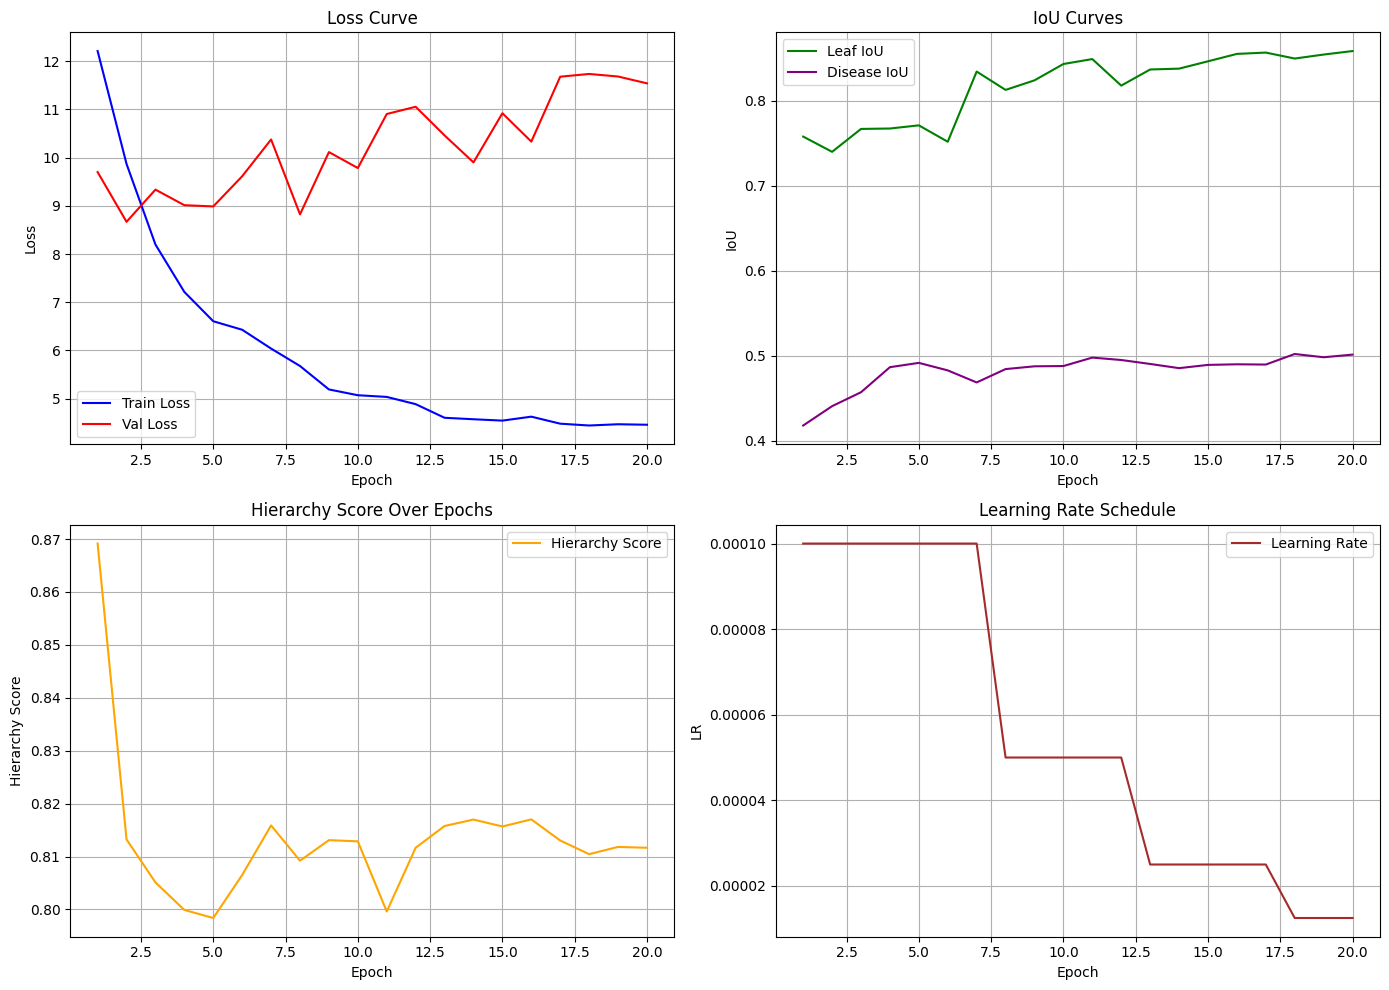

In [44]:
# =====================================================
# CELL 9 — Plot Training Metrics
# =====================================================

import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, len(history["train_loss"]) + 1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# -----------------------------------------
# 1. Loss curves
# -----------------------------------------
axes[0, 0].plot(epochs, history["train_loss"], label="Train Loss", color='blue')
axes[0, 0].plot(epochs, history["val_loss"], label="Val Loss", color='red')
axes[0, 0].set_title("Loss Curve")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# -----------------------------------------
# 2. IoU curves (Leaf + Disease)
# -----------------------------------------
axes[0, 1].plot(epochs, history["leaf_iou"], label="Leaf IoU", color='green')
axes[0, 1].plot(epochs, history["disease_iou"], label="Disease IoU", color='purple')
axes[0, 1].set_title("IoU Curves")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("IoU")
axes[0, 1].legend()
axes[0, 1].grid(True)

# -----------------------------------------
# 3. Hierarchy Score (Disease ⊂ Leaf)
# -----------------------------------------
axes[1, 0].plot(epochs, history["hierarchy"], label="Hierarchy Score", color='orange')
axes[1, 0].set_title("Hierarchy Score Over Epochs")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Hierarchy Score")
axes[1, 0].legend()
axes[1, 0].grid(True)

# -----------------------------------------
# 4. Learning Rate Curve
# -----------------------------------------
axes[1, 1].plot(epochs, history["lr"], label="Learning Rate", color='brown')
axes[1, 1].set_title("Learning Rate Schedule")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("LR")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig("training_metrics.png", dpi=200)
plt.show()


In [45]:
import torch.nn.functional as F

def upsample_disease(pred_raw, size=(256,256)):
    """
    pred_raw : tensor [1,8,8]  (from model)
    returns  : tensor [1,256,256]  (full resolution)
    """
    pred_up = F.interpolate(
        pred_raw.unsqueeze(1),   # [1,1,8,8]
        size=size,
        mode="bilinear",
        align_corners=False
    ).squeeze(1)                # [1,256,256]
    
    return pred_up


In [46]:
def binarize(pred_up, thresh=0.0):
    """
    Convert logits to binary mask.
    """
    return (pred_up > thresh).float()   # [1,256,256]


In [47]:
def compute_confusion(pred_mask, gt_mask):
    """
    pred_mask, gt_mask : [256,256] float tensors
    
    Returns TP, FP, FN, TN as ints.
    """
    pred = pred_mask.cpu().numpy()
    gt   = gt_mask.cpu().numpy()

    TP = int(((pred == 1) & (gt == 1)).sum())
    FP = int(((pred == 1) & (gt == 0)).sum())
    FN = int(((pred == 0) & (gt == 1)).sum())
    TN = int(((pred == 0) & (gt == 0)).sum())

    return TP, FP, FN, TN


In [48]:
def compute_metrics(TP, FP, FN, TN):
    sensitivity = TP / (TP + FN + 1e-6)
    specificity = TN / (TN + FP + 1e-6)
    accuracy    = (TP + TN) / (TP + TN + FP + FN + 1e-6)

    return sensitivity, specificity, accuracy


In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn.functional as F

# --------------------------
# Define helper functions
# --------------------------

def upsample_disease(logits):
    """Upsample model logits (8×8 -> 256×256)."""
    return F.interpolate(
        logits.unsqueeze(0).unsqueeze(0), 
        size=(256,256), 
        mode="bilinear",
        align_corners=False
    ).squeeze(0).squeeze(0)

def binarize(logits, threshold=0.2):
    """Convert disease logits to binary mask."""
    return (torch.sigmoid(logits) > threshold).float()

def compute_confusion(pred, gt):
    """
    pred: [256,256] float tensor (0/1)
    gt:   [256,256] float tensor (0/1)
    """
    pred = pred.cpu().numpy()
    gt = gt.cpu().numpy()

    TP = np.logical_and(pred == 1, gt == 1).sum()
    FP = np.logical_and(pred == 1, gt == 0).sum()
    FN = np.logical_and(pred == 0, gt == 1).sum()
    TN = np.logical_and(pred == 0, gt == 0).sum()
    return TP, FP, FN, TN


# --------------------------
# FIXED PATHS
# --------------------------
image_dir = Path("/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images")
mask_dir = Path("/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks")

image_paths = sorted(list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png")))

print(f"Found {len(image_paths)} test images.")

TP_total = FP_total = FN_total = TN_total = 0

# --------------------------
# EVALUATION LOOP
# --------------------------

for img_path in image_paths:

    # ---- LOAD IMAGE ----
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Cannot load image: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))

    img_t = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).float()/255.
    img_t = img_t.to(device)

    # ---- LOAD GT MASK ----
    stem = img_path.stem
    gt_path = mask_dir / f"{stem}.png"

    if not gt_path.exists():
        print(f"⚠️ GT NOT FOUND FOR: {stem}")
        continue
        
    gt = cv2.imread(str(gt_path), cv2.IMREAD_GRAYSCALE)
    gt = cv2.resize(gt, (256,256), interpolation=cv2.INTER_NEAREST)
    gt = (gt > 0).astype(np.float32)
    gt_t = torch.from_numpy(gt).float()

    # ---- FORWARD PASS ----
    with torch.no_grad():
        out = model(img_t)

    pred_raw = out["disease"][0]  # 8×8

    # ---- UPSAMPLE TO 256×256 ----
    pred_up = upsample_disease(pred_raw)

    # ---- BINARIZE ----
    pred_mask = binarize(pred_up)

    # ---- COMPUTE CONFUSION ----
    TP, FP, FN, TN = compute_confusion(pred_mask, gt_t)

    TP_total += TP
    FP_total += FP
    FN_total += FN
    TN_total += TN


Found 2940 test images.


In [61]:
def compute_all_metrics(TP, FP, FN, TN):
    eps = 1e-6

    sensitivity = TP / (TP + FN + eps)     # Recall, TPR
    specificity = TN / (TN + FP + eps)
    precision   = TP / (TP + FP + eps)
    npv         = TN / (TN + FN + eps)
    accuracy    = (TP + TN) / (TP + TN + FP + FN + eps)
    f1          = 2 * precision * sensitivity / (precision + sensitivity + eps)
    iou         = TP / (TP + FP + FN + eps)
    dice        = 2 * TP / (2 * TP + FP + FN + eps)
    fallout     = FP / (FP + TN + eps)     # False positive rate (1 - specificity)

    return {
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Precision": precision,
        "NPV": npv,
        "Accuracy": accuracy,
        "F1": f1,
        "IoU": iou,
        "Dice": dice,
        "Fallout": fallout
    }


In [62]:
def evaluate_thresholds(scores, gts, thresholds=np.linspace(0.05, 0.95, 19)):
    results = []

    for th in thresholds:
        TP = FP = FN = TN = 0

        for pred_up, gt_t in zip(scores, gts):
            pred_bin = (pred_up > th).float()

            tp, fp, fn, tn = compute_confusion(pred_bin, gt_t)
            TP += tp; FP += fp; FN += fn; TN += tn

        metrics = compute_all_metrics(TP, FP, FN, TN)
        metrics["threshold"] = th
        results.append(metrics)

    return results


In [63]:
per_image_metrics = []

def compute_per_image_metrics(pred_mask, gt_mask):
    TP, FP, FN, TN = compute_confusion(pred_mask, gt_mask)
    return compute_all_metrics(TP, FP, FN, TN)


In [66]:
TP_total = FP_total = FN_total = TN_total = 0
scores_raw = []  # logits-upsampled predictions
gts_raw = []     # GT masks

for img_path in image_paths:

    img_path = Path(img_path)
    stem = img_path.stem

    # --------------- Load GT mask ---------------
    gt_path = mask_dir / f"{stem}.png"
    if not gt_path.exists():
        print("Missing GT:", stem)
        continue

    gt = cv2.imread(str(gt_path), cv2.IMREAD_GRAYSCALE)
    gt = cv2.resize(gt, (256,256), interpolation=cv2.INTER_NEAREST)
    gt = (gt > 0).astype(np.float32)
    gt_t = torch.from_numpy(gt)

    # --------------- Predict ---------------
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    img_t = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).float()/255.
    img_t = img_t.to(device)

    with torch.no_grad():
        out = model(img_t)

    pred_raw = out["disease"][0]           # [8,8]
    pred_up = upsample_disease(pred_raw)   # [256,256]

    # Store for threshold sweep
    scores_raw.append(pred_up.cpu())
    gts_raw.append(gt_t)

    # --------------- Default threshold 0.2 ---------------
    pred_bin = (pred_up > 0.2).float()

    TP, FP, FN, TN = compute_confusion(pred_bin, gt_t)
    TP_total += TP; FP_total += FP; FN_total += FN; TN_total += TN

    # Per-image metrics
    per_image_metrics.append({
        "image": stem,
        **compute_all_metrics(TP, FP, FN, TN)
    })

print("Finished evaluation for", len(scores_raw), "images.")


Finished evaluation for 2940 images.


In [67]:
final_metrics = compute_all_metrics(TP_total, FP_total, FN_total, TN_total)

print("\n=============================")
print(" FINAL DISEASE METRICS (th=0.2)")
print("=============================")
for k, v in final_metrics.items():
    print(f"{k:12s} : {v:.4f}")



 FINAL DISEASE METRICS (th=0.2)
Sensitivity  : 0.8675
Specificity  : 0.8955
Precision    : 0.6173
NPV          : 0.9720
Accuracy     : 0.8909
F1           : 0.7213
IoU          : 0.5641
Dice         : 0.7213
Fallout      : 0.1045


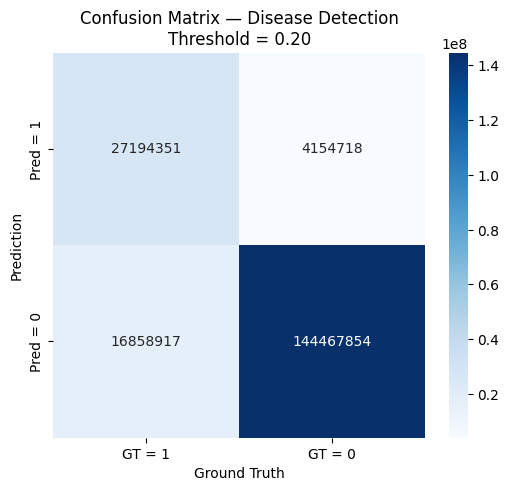

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(TP, FP, FN, TN, save_path=None):
    cm = np.array([
        [TP, FN],   # Row: Predicted = 1  (TP, FN)
        [FP, TN]    # Row: Predicted = 0  (FP, TN)
    ])

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=True,
        xticklabels=["GT = 1", "GT = 0"],
        yticklabels=["Pred = 1", "Pred = 0"]
    )

    plt.title("Confusion Matrix — Disease Detection\nThreshold = 0.20")
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")

    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

# Example usage
plot_confusion_matrix(TP_total, FP_total, FN_total, TN_total, "confusion_matrix.png")


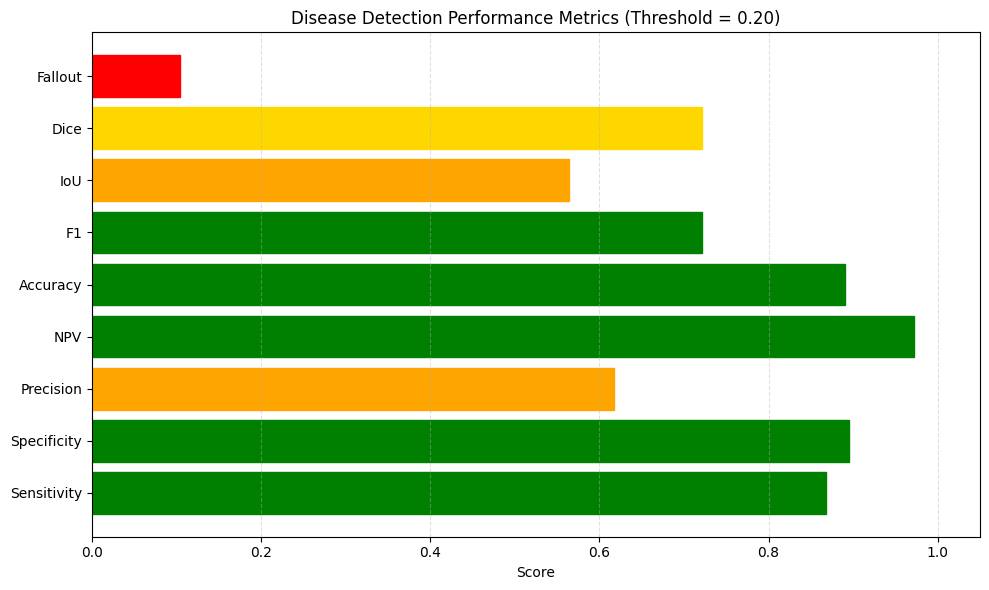

In [69]:
import matplotlib.pyplot as plt

metrics = {
    "Sensitivity"  : 0.8675,
    "Specificity"  : 0.8955,
    "Precision"    : 0.6173,
    "NPV"          : 0.9720,
    "Accuracy"     : 0.8909,
    "F1"           : 0.7213,
    "IoU"          : 0.5641,
    "Dice"         : 0.7213,
    "Fallout"      : 0.1045
}

plt.figure(figsize=(10,6))
bars = plt.barh(list(metrics.keys()), list(metrics.values()))

# Color coding
for metric, bar in zip(metrics.keys(), bars):
    if metric in ["Fallout"]:
        bar.set_color("red")
    elif metric in ["Precision", "IoU"]:
        bar.set_color("orange")
    elif metric in ["F1-score", "Dice"]:
        bar.set_color("gold")
    else:
        bar.set_color("green")

plt.xlim(0, 1.05)
plt.title("Disease Detection Performance Metrics (Threshold = 0.20)")
plt.xlabel("Score")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()

plt.savefig("disease_metrics_summary.png", dpi=150)
plt.show()


In [70]:
results = evaluate_thresholds(scores_raw, gts_raw)

# Find best threshold by F1 (or IoU)
best = max(results, key=lambda x: x["F1"])

print("\nBest threshold:", best["threshold"])
print("F1:", best["F1"])
print("IoU:", best["IoU"])



Best threshold: 0.95
F1: 0.7493208057763728
IoU: 0.599131738421245


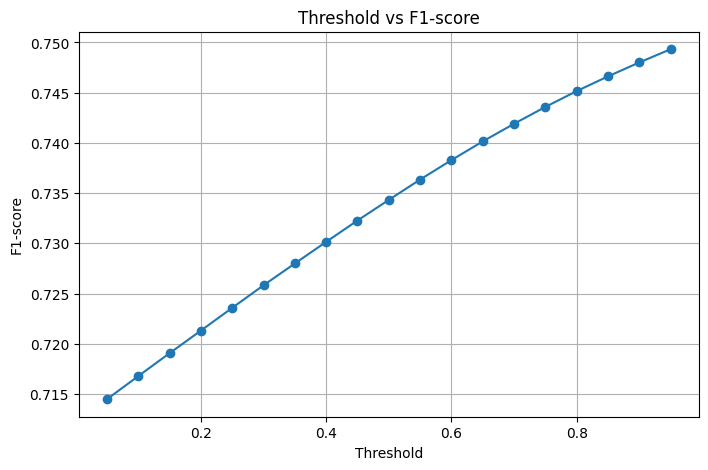

In [71]:
ths = [r["threshold"] for r in results]
f1s = [r["F1"] for r in results]

plt.figure(figsize=(8,5))
plt.plot(ths, f1s, marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("Threshold vs F1-score")
plt.grid(True)
plt.show()


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def flatten_mask(mask):
    """Convert 2D mask to 1D array for sklearn."""
    return mask.reshape(-1)

def plot_curve(x, y, score, title, xlabel, ylabel):
    plt.figure(figsize=(6,5))
    plt.plot(x, y, label=f"AUC = {score:.4f}")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [73]:
all_preds = []
all_gts = []

model.eval()
image_dir = Path("/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images")

for img_path in image_dir.glob("*.jpg"):
    stem = img_path.stem
    gt_path = mask_dir / f"{stem}.png"
    if not gt_path.exists():
        continue

    # load image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    img_t = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).float().to(device) / 255.

    # forward
    with torch.no_grad():
        out = model(img_t)

    logits_raw = out["disease"][0]                 # [8,8]
    logits_up  = upsample_disease(logits_raw)      # [256,256]

    pred_prob = torch.sigmoid(logits_up).cpu().numpy()
    gt = cv2.imread(str(gt_path), cv2.IMREAD_GRAYSCALE)
    gt = cv2.resize(gt, (256,256), interpolation=cv2.INTER_NEAREST)
    gt = (gt > 0).astype(np.float32)

    all_preds.append(flatten_mask(pred_prob))
    all_gts.append(flatten_mask(gt))

# convert lists to arrays
all_preds = np.concatenate(all_preds)
all_gts   = np.concatenate(all_gts)


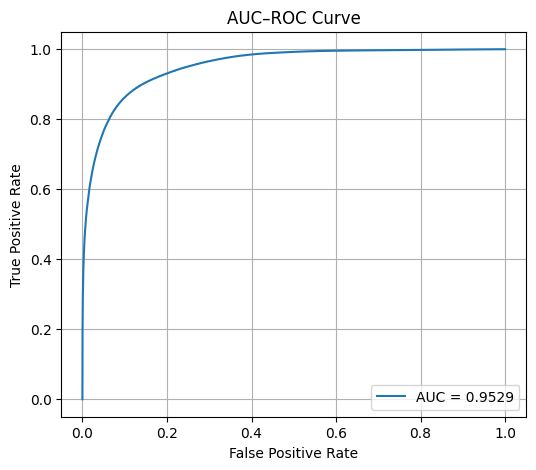

In [74]:
#------------------------------------------
# AUC-ROC CURVE 
#------------------------------------------

fpr, tpr, _ = roc_curve(all_gts, all_preds)
roc_auc = auc(fpr, tpr)

plot_curve(fpr, tpr, roc_auc,
           title="AUC–ROC Curve",
           xlabel="False Positive Rate",
           ylabel="True Positive Rate")


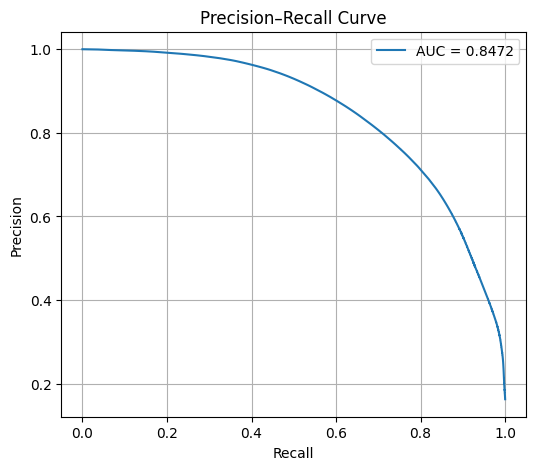

In [76]:
#------------------------------------------
# Precision–Recall Curve
#------------------------------------------
prec, rec, _ = precision_recall_curve(all_gts, all_preds)
pr_auc = auc(rec, prec)

plot_curve(rec, prec, pr_auc,
           title="Precision–Recall Curve",
           xlabel="Recall",
           ylabel="Precision")


In [ ]:
# CELL 10: single image inference + metrics
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing (same normalization as training)
infer_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

def load_model_for_inference(checkpoint_path=None, pretrained=False):
    """
    Builds model (ConvNeXtTinyHierarchical) and optionally loads checkpoint dict
    """
    m = ConvNeXtTinyHierarchical(pretrained=pretrained).to(device)
    m.eval()
    if checkpoint_path:
        ck = torch.load(checkpoint_path, map_location=device)
        # checkpoint may be state_dict or full dict; attempt to detect
        if isinstance(ck, dict) and "model_state_dict" in ck:
            sd = ck["model_state_dict"]
        elif isinstance(ck, dict) and any(k.startswith("layer") or "conv" in k for k in ck.keys()):
            # likely a raw state dict
            sd = ck
        else:
            sd = ck
        try:
            m.load_state_dict(sd)
            print("✅ Weights loaded successfully")
        except Exception as e:
            print("⚠️ Could not load weights directly:", e)
            # try forgiving load
            m.load_state_dict(sd, strict=False)
            print("⚠️ Loaded with strict=False (check missing/unexpected keys).")
    return m

def run_and_visualize(model, image_path, checkpoint_path=None, save_path="inference_output.png",
                      disease_thresh=0.2, leaf_thresh=0.5, return_dict=False):
    # optionally load weights (if checkpoint supplied)
    if checkpoint_path:
        model = load_model_for_inference(checkpoint_path, pretrained=False).to(device)
    model.eval()

    # load image
    img = np.array(Image.open(image_path).convert("RGB"))
    h0, w0 = img.shape[:2]

    aug = infer_transform(image=img)
    inp = aug["image"].unsqueeze(0).to(device)  # 1 x C x H x W

    with torch.no_grad():
        preds = model(inp)

    # get logits (NOTE: some heads produce B x H x W or B x 1 x H x W)
    leaf_logits = preds["instance"]["leaf_masks"]  # expect shape B x H1 x W1 OR B x 1 x H1 x W1
    disease_logits = preds["disease"]

    # normalize shapes -> ensure B x 1 x H x W before sigmoid / upsample
    if leaf_logits.dim() == 3:
        leaf_logits = leaf_logits.unsqueeze(1)
    if disease_logits.dim() == 3:
        disease_logits = disease_logits.unsqueeze(1)

    # Upsample both to 256x256 (same as train)
    leaf_logits_up = torch.nn.functional.interpolate(leaf_logits, size=(256, 256), mode="bilinear", align_corners=False)
    disease_logits_up = torch.nn.functional.interpolate(disease_logits, size=(256, 256), mode="bilinear", align_corners=False)

    # Prob maps
    leaf_prob = torch.sigmoid(leaf_logits_up[0,0]).cpu().numpy()
    disease_prob = torch.sigmoid(disease_logits_up[0,0]).cpu().numpy()

    # Binary masks
    leaf_mask = (leaf_prob > leaf_thresh).astype(np.uint8)
    disease_mask = (disease_prob > disease_thresh).astype(np.uint8)

    # resize back to original image size for overlay
    leaf_mask_full = np.array(Image.fromarray(leaf_mask.astype(np.uint8)*255).resize((w0, h0), resample=Image.NEAREST))//255
    disease_mask_full = np.array(Image.fromarray(disease_mask.astype(np.uint8)*255).resize((w0, h0), resample=Image.NEAREST))//255

    # Metrics (no ground truth)
    total_px = h0 * w0
    leaf_area = int(leaf_mask_full.sum())
    disease_area = int(disease_mask_full.sum())
    leaf_coverage = 100.0 * leaf_area / total_px
    disease_coverage = 100.0 * disease_area / total_px

    # disease inside leaf fraction (hierarchy)
    if disease_area > 0:
        disease_inside = int(((disease_mask_full == 1) & (leaf_mask_full == 1)).sum())
        disease_in_leaf_frac = 100.0 * disease_inside / disease_area
        hierarchy_score = disease_inside / (disease_area + 1e-9)
    else:
        disease_inside = 0
        disease_in_leaf_frac = 0.0
        hierarchy_score = 0.0

    # IoU if user provides GT later (placeholders)
    # Visualize: 3 panels original / leaf overlay / disease overlay / overlay combined
    fig, axes = plt.subplots(1, 3, figsize=(18,6))
    axes[0].imshow(img); axes[0].set_title("Original")
    axes[1].imshow(img)
    axes[1].imshow(leaf_mask_full, alpha=0.45)
    axes[1].set_title(f"Leaf (mask)  cov={leaf_coverage:.2f}%")
    axes[2].imshow(img)
    # show disease in two colors: inside-leaf (yellow) and outside-leaf (red)
    # create overlay: 0 none, 1 disease inside, 2 disease outside
    overlay = np.zeros((h0, w0), dtype=np.uint8)
    overlay[(disease_mask_full==1) & (leaf_mask_full==1)] = 1
    overlay[(disease_mask_full==1) & (leaf_mask_full==0)] = 2
    # show inside as yellow-ish (map=YlOrRd) and outside as red (we will use alpha)
    axes[2].imshow(img)
    axes[2].imshow(np.where(overlay==1, 1, 0), alpha=0.45, cmap="YlOrBr")
    axes[2].imshow(np.where(overlay==2, 1, 0), alpha=0.45, cmap="Reds")
    axes[2].set_title(f"Disease cov={disease_coverage:.2f}%, in-leaf={disease_in_leaf_frac:.2f}%")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

    # Print & return metrics
    print("\n🔍 Inference summary for:", image_path)
    print(f"  Leaf coverage:    {leaf_coverage:.2f}%  (pixels={leaf_area})")
    print(f"  Disease coverage: {disease_coverage:.2f}%  (pixels={disease_area})")
    print(f"  Disease inside leaf: {disease_in_leaf_frac:.2f}%  (pixels={disease_inside})")
    print(f"  Hierarchy score (fraction disease inside leaf): {hierarchy_score:.4f}")

    out = {
        "leaf_coverage": leaf_coverage,
        "disease_coverage": disease_coverage,
        "disease_inside_percent": disease_in_leaf_frac,
        "hierarchy_score": hierarchy_score,
        "counts": {"leaf_area": leaf_area, "disease_area": disease_area, "disease_inside": disease_inside},
        "overlay_path": str(Path(save_path).resolve())
    }
    if return_dict:
        return out
    else:
        return None


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
from PIL import Image
from IPython.display import FileLink

# ===============================================================
# Load ORIGINAL image + ORIGINAL mask (NO AUGMENTATION)
# ===============================================================
def load_original(img_path, mask_root):
    # Load raw image
    img = np.array(Image.open(img_path).convert("RGB"))

    # Find mask file
    stem = Path(img_path).stem
    mask_path = Path(mask_root) / f"{stem}.png"

    if mask_path.exists():
        mask = np.array(Image.open(mask_path).convert("L"))
    else:
        mask = np.zeros(img.shape[:2], dtype=np.uint8)

    return img, mask


# ===============================================================
# VISUALIZE + SAVE ORIGINAL SAMPLE
# ===============================================================
def show_and_save_original(img_path, mask_root, prefix, idx, save_dir="samples_raw"):
    os.makedirs(save_dir, exist_ok=True)

    img, mask = load_original(img_path, mask_root)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(img)
    axs[0].set_title(f"{prefix} Image {idx} (ORIGINAL)")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="Reds")
    axs[1].set_title("Disease Mask (ORIGINAL)")
    axs[1].axis("off")

    save_path = f"{save_dir}/{prefix}_{idx}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close()

    print(f"Saved → {save_path}")
    return save_path


# ===============================================================
# RANDOM SAMPLE GENERATION
# ===============================================================
def generate_random_samples(dataset_paths, mask_dir, prefix, n=3):
    saved = []
    all_images = list(dataset_paths)

    np.random.seed(42)
    idxs = np.random.choice(len(all_images), n, replace=False)

    for i in idxs:
        saved.append(
            show_and_save_original(all_images[i], mask_dir, prefix, i)
        )

    return saved


# ===============================================================
# COLLECT IMAGE PATHS
# ===============================================================
train_images = sorted(list((Path(PLANTDOC_DISEASE_DIR) / "aug_data/aug_data/images").glob("*.jpg")))
mask_dir    = Path(PLANTDOC_DISEASE_DIR) / "aug_data/aug_data/masks"

print(f"Found {len(train_images)} train images.")


# ===============================================================
# GENERATE RANDOM TRAIN + VAL SAMPLES
# ===============================================================
saved_files = []
saved_files += generate_random_samples(train_images, mask_dir, prefix="train", n=3)
saved_files += generate_random_samples(train_images, mask_dir, prefix="val",   n=3)


# ===============================================================
# ZIP FILE
# ===============================================================
zip_name = "original_dataset_samples.zip"
with zipfile.ZipFile(zip_name, 'w') as z:
    for f in saved_files:
        z.write(f)

print("\n📦 ZIP created:", zip_name)
display(FileLink(zip_name))


In [ ]:

# Example usage:

model = load_model_for_inference("/kaggle/working/models/best_model_composite.pth")
run_and_visualize(model, "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00015_4.jpg", checkpoint_path=None, save_path="realworld_output.png")

In [ ]:
image_path = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00001_4.jpg"

# Load your model (assuming already in memory)
model = model.to(device)

heatmap, overlay = infer_heatmap(image_path, model, device=device, 
                                 save_path="pred.jpg", cmap="inferno")


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2
from PIL import Image
import matplotlib.pyplot as plt


def extract_tensor_recursive(x):
    """Recursively extract first tensor from nested dicts/lists."""
    if torch.is_tensor(x):
        return x
    if isinstance(x, dict):
        # preferred key if exists
        if "leaf_masks" in x and torch.is_tensor(x["leaf_masks"]):
            return x["leaf_masks"]
        for v in x.values():
            t = extract_tensor_recursive(v)
            if t is not None:
                return t
    if isinstance(x, (list, tuple)):
        for v in x:
            t = extract_tensor_recursive(v)
            if t is not None:
                return t
    return None



def infer_heatmap(image_path, model, device="cuda", save_path=None, cmap="inferno"):
    """
    Runs inference, produces heatmap and overlay.
    
    Returns:
        heatmap_color (H,W,3)
        overlay (H,W,3)
    """

    # -------------------------
    # Load & preprocess image
    # -------------------------
    img = np.array(Image.open(image_path).convert("RGB"))
    orig_h, orig_w = img.shape[:2]

    aug = infer_transform(image=img)      # your same inference transform
    inp = aug["image"].unsqueeze(0).to(device)

    # -------------------------
    # Run model
    # -------------------------
    model.eval()
    with torch.no_grad():
        outputs = model(inp)

    # -------------------------
    # Extract disease logits
    # -------------------------
    if "disease" in outputs:
        disease_logits = extract_tensor_recursive(outputs["disease"])
    else:
        raise RuntimeError("Model output missing 'disease' key")

    if disease_logits.dim() == 3:
        disease_logits = disease_logits.unsqueeze(1)

    # Resize to original resolution
    disease_logits_up = F.interpolate(
        disease_logits, 
        size=(orig_h, orig_w), 
        mode="bilinear", 
        align_corners=False
    )[0,0]

    disease_prob = torch.sigmoid(disease_logits_up).cpu().numpy()

    # -------------------------
    # Make heatmap
    # -------------------------
    heatmap = (disease_prob * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap, getattr(cv2, f'COLORMAP_{cmap.upper()}', cv2.COLORMAP_INFERNO))
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # -------------------------
    # Overlay heatmap on image
    # -------------------------
    overlay = cv2.addWeighted(img, 0.55, heatmap_color, 0.45, 0)

    # -------------------------
    # Save or show
    # -------------------------
    if save_path:
        cv2.imwrite(save_path.replace(".jpg", "_heatmap.jpg"), cv2.cvtColor(heatmap_color, cv2.COLOR_RGB2BGR))
        cv2.imwrite(save_path.replace(".jpg", "_overlay.jpg"), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    # Plot inline
    plt.figure(figsize=(14,6))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(heatmap_color); plt.title("Disease Heatmap"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis('off')
    plt.show()

    return heatmap_color, overlay


In [ ]:
# CELL 11: quick model reload test
def test_model_reload(checkpoint_path="models/best_model_composite.pth"):
    try:
        m = load_model_for_inference(checkpoint_path, device=device)
        # run on a small random tensor
        x = torch.randn(1,3,IMAGE_SIZE[0],IMAGE_SIZE[1]).to(device)
        with torch.no_grad():
            out = m(x)
        assert 'instance' in out and 'leaf_masks' in out['instance'] and 'disease' in out
        print("✅ Model reload test passed.")
    except Exception as e:
        print("❌ Model reload test failed:", e)

# test_model_reload()